# Assignment 3c Cognitive Modelling

Dit is onderdeel van de derde opdracht voor Cognitive Modelling, assignment 3 bestaat in totaal uit 3 onderdelen:

* Assignment 3a (47 punten)
* Assignment 3b (19 punten)
* __Assignment 3c (23 punten)__

__Let op__: Opdracht 3b en 3c werken alleen in Google Colab!

Geef antwoorden in blokken met code of met tekst.Gebruik voor antwoorden met tekst de ">" voor blockquotes en geef bij elke vraag ook __kort uitleg__ als hier om wordt gevraagd. __Let op__: soms staan er meerdere vragen bij een onderdeel, lees de tekst dus nauwkeurig.

Sla het uiteindelijke notebook op met jullie studentnummers en achternamen in de filenaam: `studentnummer1_achternaam1_studentnummer2_achternaam2_opdrachtnummer`.

<br>

---

### Voorbereiding stap 1. De Colab environment

Koppel je notebook aan een GPU: ga naar **Edit > Notebook settings** of **Runtime > Change runtime type** en selecteer GPU as Hardware accelerator.

![screenshot](https://drive.google.com/uc?id=1QsJXUPPL0eEoWHI7a-A1_F42djdgCcBL)

and daarna:

![screenshot](https://drive.google.com/uc?id=1ODvXSxF7OBy9blmZfC1Yk870uw80c6YW)

Nu moet je jouw Google Drive koppelen aan deze omgeving zodat je daarvan kan lezen en naar kan schrijven. Het zal misschien nodig zijn om een key in te voeren. Klik daarvoor op de link die verschijnt. Die brengt je naar een google pagina, en copy paste dan je key hier in het notebook.


In [51]:
# from google.colab import drive
# drive.mount('/content/drive/')
# # verander alles achter "/content/drive/My\ Drive/" naar de locatie van de bestanden.
# %cd /content/drive/My\ Drive/STA_KI/Assignment\ 3/


In [52]:
ls

Assignment_3b_SimpleNetwork.ipynb
Assignment_3c_Doom.ipynb
Images/
_vizdoom.ini
basic.cfg
basic.wad
lr-0_02_bs-64_eps_dec-0_0001_gam-0_95.txt
models/
tensorboard/


In [53]:
ls Images/

GPU.png      Runtime.png  doom.png     preproc.png
QNET.png     doom.gif     model.png


<br>

---

### Voorbereiding stap 2. Installeer Vizdoom ☕

Nu moeten we Vizdoom en een paar dependencies installeren op de Colab. Deze twee stappen kunnen enkele minuten duren (tijd voor koffie). Let op dat als je de colab instance een tijdje niet gebruikt, je deze stap opnieuw moet doen! Net als de key for google drive geven.

In [54]:
# ## to get vizdoom to work
# ## https://stackoverflow.com/questions/50667565/how-to-install-vizdoom-using-google-colab
# ## takes a few minutes....
# %%bash
# # Install deps from https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux
# apt-get update

# apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
# nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
# libopenal-dev timidity libwildmidi-dev unzip

# # Boost libraries
# apt-get install libboost-all-dev
# # Lua binding dependencies
# apt-get install liblua5.1-dev

In [55]:

# Dan installeren we vizdoom, sk-image and imageio in the python environment
!pip install vizdoom
!pip install scikit-image
!pip install imageio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


<br>

---

### Voorbereiding stap 3. Setting up the Game environment

In [56]:
import torch
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import numpy as np
import random
import math
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from vizdoom import *
from skimage import transform

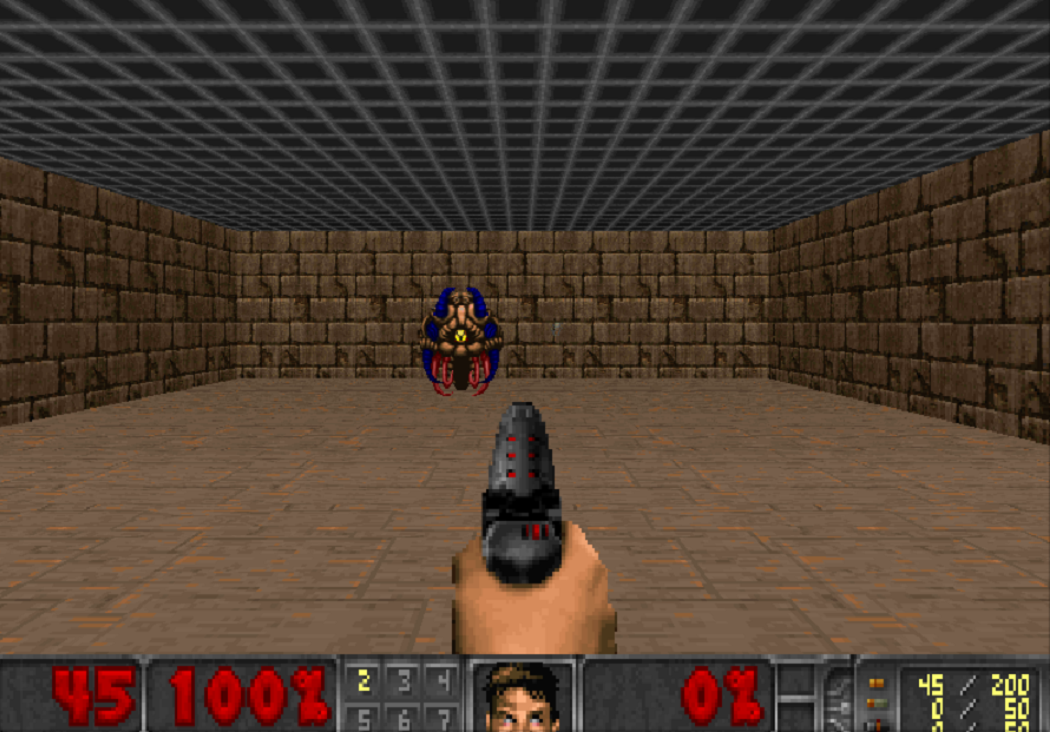

In [57]:
# plaatje van vizdoom
from IPython.display import Image
Image('Images/doom.png')

<br>

---

## De regels van het spel 🎮
Nu we alle libraries hebben, kunnen we de regels van het spel bepalen. Doom wordt bepaald door:
  - Een  `configuration file` "basic.cfg" daar in vinden alle opties (frame size, mogelijke handelingen)
  - Een `scenario file`: "basic.wad" deze genereerd het correcte scenario (ruimte, monsters etc, komt bij vizdoom) .

Open beide files met een text editor en bestudeer ze kort, kijk of je de belangrijkste elementen kan ontcijferen (en later mogelijk veranderen). Het spel ziet er als volgt uit:

__De omgeving:__
- Een monster staat op een willekeurige plek aan de overkant van het veld
- De speler heeft drie mogelijke acties: naar links, naar rechts en schieten
- 1 hit is genoeg om het monster uit te schakelen
- Een episode is over als het monster is geraakt of door een timeout (300).

__De rewards:__
- -5 punten voor het schieten van kogel  
- -1 punt voor elke tijdstap (energy consumption)
- +100 punten voor het uitschakelen van het monster uitschakelen

In [58]:
def create_environment():
    game = DoomGame()

    # Load the correct configuration
    game.load_config("basic.cfg")

    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("basic.wad")

    ## we cant watch the game perform on collab
    game.set_window_visible(False)
    game.init()

    # Here are our possible actions
    # The input for Vizdoom needs our
    # action space to be defined by one-hot
    # encoding.
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions_vizdoom = [left, right, shoot]

    # In pytorch we will simply represent our actions
    # as integers. Our action space which we will use
    # as input for pytorch is this encoded as follows:
    left = 0
    right = 1
    shoot = 2
    possible_actions_pytorch = [left, right, shoot]

    return game, possible_actions_vizdoom, possible_actions_pytorch

<br>

---

### Preprocessing ⚙️

Preprocessing is een belangrijke stap, omdat we de complexiteit van onze data willen verminderen om zo de rekentijd die nodig is voor training te verminderen. In termen van leren kan je deze stap zien als een leraar die de leerling alleen vertelt in welke richting te kijken. Minimale supervision, maar dit helpt de leerling wel door de aandacht te vestigen in de juiste richting.

__Preprocessing stappen:__
- Grijstinten maken van alle frames (omdat kleur geen belangrijke informatie toevoegt). Dit wordt al gedaan door het configuratiebestand (!).
- Het scherm bijsnijden (in ons geval verwijderen we het dak omdat het geen informatie bevat)
- Het normaliseren van de pixelwaarden
- Het verkleinen van het preprocessed frame.

Dit resulteert in een 84x84 grayscale frames.

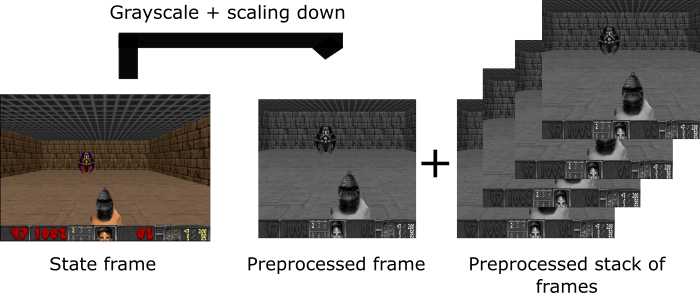

In [59]:
def preprocess_frame(frame):

    # The grayscaling is already done in our vizdoom config
    # So no need to do that here, if we would have wanted to
    # we could have used this functions:
    # from skimage.color import rgb2gray

    # Crop the screen (remove the roof because it contains no information)
    cropped_frame = frame[30:-10,30:-30]

    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0

    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [84,84])

    return preprocessed_frame

Image('Images/preproc.png')

<br>

---

### Stacked Frames 🕖🕗🕘🕙

Als input states gaan we dus nu geen single frames gebruiken, maar een stapeltje (stacked) frames. Het stapelen van frames is erg belangrijk omdat het een gevoel van beweging/tijd meegeeft aan het neurale netwerk. Eerst preprocessen we het frame, vervolgens voegen we het frame toe aan een *deque* dat automatisch het oudste frame verwijdert, dan bouwen we de state (S) van deze frames.

Dit is hoe de functie werkt:
- Voor de start state voeren we 4 keer hetzelfde begin frame in
- Bij elke tijdsstap voegen we het nieuwe frame toe aan de deque, en wordt het oudste frame weggehaald. Deze nieuwe stack is dan de nieuwe state
- Enzovoort
- Als een episode voorbij is maken we een nieuwe stapel met 4 nieuwe frames (omdat we ons in een nieuwe episode bevinden).

Hier is nog een meer in depth artikel over stacked frames:  <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  Frame skipping and preprocessing</a>.

In [60]:
def stack_frames(stacked_frames, state, is_new_episode,stack_size=4):
    # Preprocess frame
    frame = preprocess_frame(state)
    if is_new_episode:
        # Clear stacked frames and repeat the initial frame
        stacked_frames = deque([np.zeros((84,84), dtype=np.int_) for _ in range(stack_size)], maxlen=stack_size)
        for _ in range(stack_size):
            stacked_frames.append(frame)
    else:
        # Add the latest frame and automatically remove the oldest frame
        stacked_frames.append(frame)
    # Stack the frames along a new dimension
    # This is where we change the original code
    # making sure the channels are (C,H,W)
    # We can add the last channel later
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

<br>

---

### Initialiseren van hyperparameters 🎛
In dit deel stellen we de verschillende hyperparameters in. Eerst definieren we de hyperparameters van het neurale netwerk. Om de mogelijke acties die we in het spel kunnen doen op te halen uit het spel zullen we eerst vizdoom opstarten. Dit kunnen we doen door onze create_environment functie op te starten, loop nog een keer door deze functie heen om precies te zien wat die doet.

In [61]:
game, possible_actions_vizdoom, possible_actions_pytorch = create_environment()

In [62]:
### MODEL HYPERPARAMETERS
state_size = [4,84,84]
action_size = game.get_available_buttons_size()    # 3 possible actions: left, right, shoot
learning_rate =  0.0025      # Alpha (aka learning rate)
batch_size = 64  # Batch size for replay

### ❓ __Q1 (2 punten)__
Waarom is de input voor het model, `State_size`,  een matrix van 4x84x84?

> *Antwoord*
# YOrden
De matrix representeerd vier images van grootte 84x84, hierbij staat de 4x voor de vier foto's in de stack. 

---

## Deep Q-learning Neural Network model bouwen 🧠

Dit is de structuur van het Deep Q-learning model (zie ook de afbeelding hieronder):
- We nemen de stacked frames as input
- Deze input gaat door 3 convnets
- De data wordt platgeslagen (flattened), en gaat dan door twee fully connected layers.

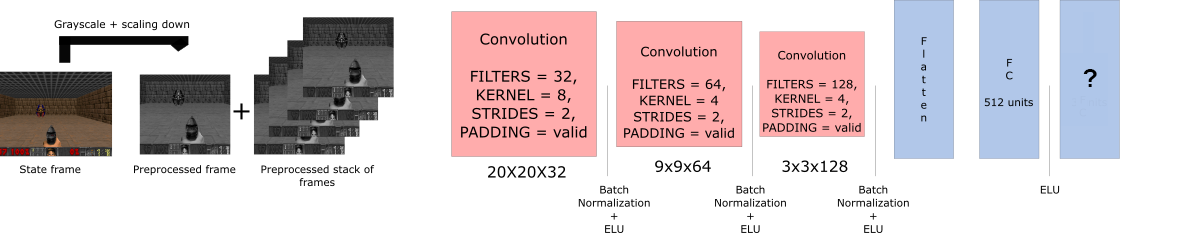

In [63]:
Image('Images/model.png')

Bestudeer de code onder vraag 3 bij `class DQNetwork`, kijk in hoeverre je de structuur zoals hier boven beschreven terug kan lezen. Het is nu niet belangrijk dat alle details helemaal begrijpt, maar wel de grote lijnen.

<br>

### ❓__Q2. Network Questions (4 punten)__

1. Hoeveel nodes heeft de laatse laag, en wat representeert deze laag?
2. Welke activatie functie gebruikt het netwerk?
3. En welke loss functie wordt er geminimalizeerd?

> *Antwoord*
# moet nog gemaakt worden !!!!!! oynem!!!
1. Hoeveel nodes heeft de laatse laag, en wat representeert deze laag?
- 
2. Welke activatie functie gebruikt het netwerk?
- het model gebruikt de activation function:  Exponential Linear Unit (ELU)
3. En welke loss functie wordt er geminimalizeerd?
- De mean sqaured error wordt geminimaliseedr

<br>

Als het goed is heb je bij Computer Vision alles over Convnets geleerd en ook bij andere vakken over ANNs. Maar om toch even kort terug naar de theorie. Waarom gebruiken we hier niet een simpel one-layer network, of waarom geen Q-tables zoals we hiervoor hebben gedaan? De reden is de grootte van de state space.


### ❓__Q3. (2 punten)__
Hoe groot is de state space (na pre-processing) en hoeveel state, action pairs zijn er dus?

> *Antwoord*

<br>

Precies! Dat is al heel erg groot en dit spel is nog steeds erg beperkt. Stel je voor dat je nog door de ruimte kan bewegen etc. We zagen al dat het grotere Frozen Lake van 8x8 lastig was voor Q-tables. Dit is niet te doen. Convnets kunnen de agent de state space laten doorgronden en laten generalizeren.

Een convnet kan gebruik maken van spatiele relaties: denk bijvoorbeeld aan dat als het monster twee stappen links van jou staat, je altijd LEFT, LEFT, SHOOT zou moeten doen, ongeacht of het monster helemaal links staat of in het midden. Als je deze relaties kan gebruiken om te leren is dat dus heel handig. Een Q-table aanpak zou voor state monster_links en state monster_midden geheel opnieuw moeten leren wat de beste actie is.

Meer lezen over convolutional nets:
https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [64]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size, learning_rate=learning_rate):
        super(DQNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=state_size[0], out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(num_features=32,eps=1e-5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(num_features=64,eps=1e-5)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(num_features=128,eps=1e-5)

        # Xavier initialization
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)

        # Calculate the size of the flattened output after the last convolutional layer
        self.fc_input_dim = self._get_conv_output_dim(state_size)

        # Fully connected layers
        self.fc = nn.Linear(in_features=self.fc_input_dim, out_features=512)
        self.output_layer = nn.Linear(in_features=512, out_features=action_size)

        # Xavier initialization for fully connected layers
        torch.nn.init.xavier_uniform_(self.fc.weight)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

        # Optimizer
        self.optimizer = optim.RMSprop(self.parameters(), lr=learning_rate)

    def forward(self, x):
        # Forward pass through convolutions
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Forward pass through the fully connected layer
        x = F.elu(self.fc(x))
        x = self.output_layer(x)

        return x

    def _get_conv_output_dim(self, input_shape):
        # Dummy pass to get the output shape
        return self._forward_features(torch.zeros(1, *input_shape)).view(1, -1).size(1)

    def _forward_features(self, x):
        # Helper function to pass input through convolutional layers
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))

        return x

<br>

---

### De hyperparameters voor de training 🎛
In dit deel voegen we de trainingshyperparameters toe:

In [65]:
# Hyperparameters
episodes = 501  # Total episodes for training
max_steps = 100  # Max possible steps in an episode
epsilon_start = 1.0  # Initial exploration probability
epsilon_end = 0.01  # Minimum exploration probability
epsilon_decay = 0.0001  # Exponential decay rate for exploration prob
gamma = 0.95  # Discounting rate for future rewards

pretrain_length = batch_size  # Number of experiences stored in the Memory when initialized for the first time
memory_size = 10000  # Number of experiences the Memory can keep

training = True  # Modify this to False if you just want to see the trained agent
episode_render = False  # Turn this to True if you want to render the environment (visualize the agent)


<br>

---

### Experience Replay 🔁
Nu we ons neurale netwerk hebben gemaakt, gaan we de Experience Replay-methode implementeren. Eerst maken we een deque Memory-object. Een deque (dubbele wachtrij) is een gegevenstype dat het oudste element verwijdert telkens wanneer er een nieuw element wordt toegevoegd.

In [66]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        return [self.buffer[i] for i in index], buffer_size

Hier zullen we het probleem aanpakken dat de agents beginnen met een volledig leeg geheugen: we vullen ons geheugen vooraf in door willekeurige acties te ondernemen en de ervaring op te slaan (*state, action, reward, new_state*).

In [67]:
def fill_up_memory(memory_size, pretrain_length):

    memory = Memory(max_size=memory_size)  # Initialize memory
    game.new_episode()  # Start a new episode in the environment

    stack_size = 4 # We stack 4 frames
    stacked_frames  =  deque([np.zeros((84,84), dtype=np.int_) for i in range(stack_size)], maxlen=stack_size) # Initialize deque with zero-images one array for each image

    for i in range(pretrain_length):
        if i == 0:
            state = np.array(game.get_state().screen_buffer)
            state, stacked_frames = stack_frames(stacked_frames, state, True, stack_size)  # Initial state

        action = random.choice(possible_actions_pytorch)  # Choose a random action
        reward = game.make_action(possible_actions_vizdoom[action])  # Execute the action, reward is returned
        done = game.is_episode_finished()  # Check if episode is done

        if done:
            # Episode ended
            next_state = np.zeros(state.shape) # Fill next state with zeros
            memory.add((state, action, reward, next_state, done)) # Add experience to memory

            game.new_episode()  # Start a new episode
            state = game.get_state().screen_buffer  # Get the new initial state
            state, stacked_frames = stack_frames(stacked_frames, state, True, stack_size)  # Restack frames
        else:
            # Episode continues
            next_state = game.get_state().screen_buffer # Get the next state
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False, stack_size)
            memory.add((state, action, reward, next_state, done))
            state = next_state  # Update the current state

    return memory, stacked_frames

<br>

---

### Tensorboard 📊

We gebruiken deze functie om de data van de training weg te schrijven.

In [68]:
# Initialize the SummaryWriter
def initialize_tensorboard(path_tensorboard,run_id):
    writer = SummaryWriter(f"{path_tensorboard}/{run_id}/")

    return writer

Hieronder definiëren we de keuzefunctie van de agent. We implementeren een  klassieke e-greedy keuzeregel met exponentiële afname in exploratie. Een nieuwigheid is dat er een ondergrens is voor de parameter **explore_stop**.

In [69]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions, model, device):
    # Epsilon Greedy Strategy
    # Calculate explore probability
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    # Randomize a number
    exp_exp_tradeoff = np.random.rand()

    # we do a random move based on the explore probability:
    if exp_exp_tradeoff > explore_probability:
        # Make a random action (explore)
        action = random.choice(possible_actions)
    # otherwise we get our model to do a move based on the state
    else:
        # Get action from DQN (exploit)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add a batch dimension and send to device
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            Qs = model(state)
        model.train()  # Set the model back to train mode

        # output of our model is a factor, containing the probabilities (Q-values)
        # for the moves, we choose the one with the highest probability:
        # Select the action with the highest Q-value
        action = torch.argmax(Qs).detach().item()
        state.detach()
        del state

    return action, explore_probability

In [70]:
def optimize_model(experiences, policy_net, optimizer, gamma, device):
    # first we unpack the experiences, the experiences are drawn from memory
    # and are as many as the batch size. Each experience is a tuple containing
    # the state, action, reward, next_state and if the episode is done or not.
    states, actions, rewards, next_states, dones = zip(*experiences)

    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(np.array(actions)).unsqueeze(-1).to(device)  # Ensure actions are long and have correct shape
    rewards = torch.FloatTensor(np.array(rewards)).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(np.array(dones)).to(device)

    # Get Q values for the chosen actions, this gathers all the Q values for the actions
    # provided in the actions tensor, which correspond to the states in the batch.
    current_q_values = policy_net(states).gather(1, actions)

    # Here we predict the q-values for the next states, given the current policy network
    # and we detach the values, so that we do not backpropagate through the target network.
    next_q_values = policy_net(next_states).detach().max(1)[0]
    # Compute the target Q values for the current states
    # based on $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
    # the 1-dones is used to make sure that the target is equal to the reward
    # when the episode is done.
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    # Compute loss
    loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Delete all the tensors! We do not want to keep them in memory.

    del states, actions, rewards, next_states, dones
    del current_q_values, target_q_values, next_q_values

    return loss.detach().item()

<br>

---

## Training 🏃‍♂️

Ons algoritme:
<br>
* Initialiseer de weigths van het netwerk
* Initialiseer de game omgeving
* Initialiseer de decay rate voor e-greedy
<br>
* **For** episode to max_episode **do**
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br>
    * **While** step < max_steps **do**:
        * Increase decay_rate (decreas decay)
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$

Je ziet dat dit eigenlijk precies hetzelfde is als we eerder in het FrozenLake Q-net hadden geimplementeerd, alleen zitten er nu dus wel wat lagen tussen.

<br>

### ❓ __Q4.a (7 punten)__

Je gaat hieronder de agent trainen in 500 episodes met de huidige set hyperparameters, dit kan wel ongeveer 10 minuten duren, dus tijd om even pauze te nemen en de benen te strekken. Bekijk en rapporteer na afloop het gedrag van de agent tijdens het leerproces. Dit kan op twee manieren:

1. Aan de hand van de score die de agent behaalt tijdens het leren;
2. Aan de hand van hoe de agent het spel speelt (visueel).

__1. Score__
  
  * Tijdens het trainen schrijft het script de output weg in **test.txt** die kan worden gebruikt voor visualisatie van de leercurve(s). Deze wordt dus in je Google Drive geschreven. Geef deze file een andere naam die specifiek is voor setttings van het netwerk dat je traint, zo kan je later modelen vergelijken.
  * Maak twee plots op basis van deze data: de leercurve met de score van de agent tijdens het leren, de kans op een exploratie. Zet in de grafieken de gemiddelde punten en explore probabilities voor bins van 10 episodes om de leercurven te illustreren en rapporteer ook het totaal aantal punten. Beschrijf wat je ziet.

__2. Visualisatie__

* De code hieronder slaat het model om de 50 episodes `model_XX.ckpt.` op in de directory `models`. Dit is de staat van het model na XX episodes trainen. De filenames specificeren dus weer het model.

  Met de code onder vraag 5 kan je de boven genoemde outputfiles gebruiken om naar gedrag van de agent te kijken, gegeven de weights in het netwerk na een een XX aantal leer episodes. Deze code laat slechts één game zien (één episode), dus doe dit misschien een aantal keer omdat het anders net zo kan uitvallen dat de game begint dat de agent recht voor de alien staat en meteen neerschiet. Dat is goed maar vertelt weinig over het gedrag.

  Naast deze ene game, slaat deze code ook de sequentie van states als lijst van screenshots op in `trajectory`. Deze `trajectory` kan je in een animatie te maken door ze achter elkaar te plakken. Je kan deze  bekijken, en ook opslaan als mp4.
  
* Beschrijf het verschil in gedrag in drie verschillende fasen (episode 50, 150 en 500). Wat voor soort fouten zie je? Sla de vier .mp4 bestanden van deze drie fases op en __lever de bestanden in__.

_Let op: voor sommigen werkt de functie_ `save_path = saver.save(sess, "./models/model_{}.ckpt".format(episode)` _niet altijd goed. Het is niet duidelijk waarom, maar dan kan je dit deel van de opdracht helaas niet helemaal doen, laat dit weten aan je TA._

In [71]:
# Define the name of your run
# for tensorboard and logfiles:
path_tensorboard="./tensorboard/"
run_id= "lr-0_02_bs-64_eps_dec-0_0001_gam-0_95"

# initialize tensorboard:
writer = initialize_tensorboard(path_tensorboard,run_id)

In [72]:
# Setup torch
torch.backends.cudnn.enabled = False  # Disable CuDNN for eficient execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize network, optimizer, memory
dqn_network = DQNetwork(state_size, action_size).to(device)
optimizer = optim.RMSprop(dqn_network.parameters(), lr=learning_rate)
# fill up the memory with enough samples to
# take one batch for optimization of the network
memory, stacked_frames = fill_up_memory(memory_size, batch_size)

# The global step is used to adjust the epsilon value
# This is input for the decay step in the predict action
# It will lower our exploration rate as it increases
global_step=0

# create the directory to save the models
# if the directory does not exist yet
if not os.path.exists(f"./models/model_{run_id}/"):
    os.makedirs(f"./models/model_{run_id}")

for episode in range(episodes+1):
    # Choose what text file you want to save the progress of your run in.
    with open(f"{run_id}.txt","a+") as f:
        game.new_episode()  # Starts a new episode
        state = game.get_state().screen_buffer  # Gets the initial state
        state, stacked_frames = stack_frames(stacked_frames, state, True)  # Initial state
        total_reward = 0
        done = game.is_episode_finished()
        episode_step = 0  # Reset global_step at the start of each episode if it's episode-wise

        while episode_step<max_steps and not done:
            episode_step += 1  # Increment total steps for the episode
            global_step += 1  # Increment decay step

            # Select action based on the current state and epsilon
            action, explore_probability = predict_action(epsilon_start, epsilon_end, epsilon_decay, global_step, state, possible_actions_pytorch, dqn_network, device)

            # Execute action
            reward = game.make_action(possible_actions_vizdoom[action]) # do a move based on the action from predict_action
            done = game.is_episode_finished()  # Check if the episode is finished
            if not done:
                next_state = game.get_state().screen_buffer
            else:
                next_state = np.zeros((84,84), dtype=np.int_)  # Use a zero array for the final state

            # Stack the frames of the next state
            # This also processes the frames
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

            # Accumulate total reward
            total_reward += reward

            # Save experience to memory
            memory.add((state, action, reward, next_state, done))

            if len(memory.buffer) > batch_size:

                experiences, buffer_size = memory.sample(batch_size)
                loss = optimize_model(experiences, dqn_network, optimizer, gamma, device)

            state = next_state  # Update state
            del experiences, next_state # delete everything to make sure memory usage is optimized

            # Logging
        writer.add_scalar('Total Reward/Episode', total_reward, episode)
        writer.add_scalar('Loss/Episode', loss, episode)
        log_info = f"Episode: {episode}\tTotal Reward: {total_reward}\tExplore P: {explore_probability:.4f}\tTraining Loss: {loss:.4f}\tBuffer size: {buffer_size:.4f}\n"
        print(log_info.strip())  # Print episode summary
        f.write(log_info)  # Write episode summary to file
        if episode % 50 == 0:
            torch.save(dqn_network.state_dict(), "./models/model_{}/episode_{}.pth".format(run_id,episode))
            print("Model Saved")

# Close the writer after training
writer.close()

Episode: 0	Total Reward: -125.0	Explore P: 0.9901	Training Loss: 1.4353	Buffer size: 164.0000
Model Saved
Episode: 1	Total Reward: -120.0	Explore P: 0.9804	Training Loss: 1.9658	Buffer size: 264.0000
Episode: 2	Total Reward: -125.0	Explore P: 0.9707	Training Loss: 1.0101	Buffer size: 364.0000
Episode: 3	Total Reward: 70.0	Explore P: 0.9682	Training Loss: 0.5833	Buffer size: 390.0000
Episode: 4	Total Reward: -130.0	Explore P: 0.9587	Training Loss: 2.8081	Buffer size: 490.0000
Episode: 5	Total Reward: 95.0	Explore P: 0.9581	Training Loss: 2.1353	Buffer size: 496.0000
Episode: 6	Total Reward: 95.0	Explore P: 0.9576	Training Loss: 3.0163	Buffer size: 502.0000
Episode: 7	Total Reward: 71.0	Explore P: 0.9552	Training Loss: 10.3620	Buffer size: 527.0000
Episode: 8	Total Reward: -130.0	Explore P: 0.9458	Training Loss: 252.2459	Buffer size: 627.0000
Episode: 9	Total Reward: 95.0	Explore P: 0.9452	Training Loss: 24.8345	Buffer size: 633.0000
Episode: 10	Total Reward: -125.0	Explore P: 0.9359	Tra

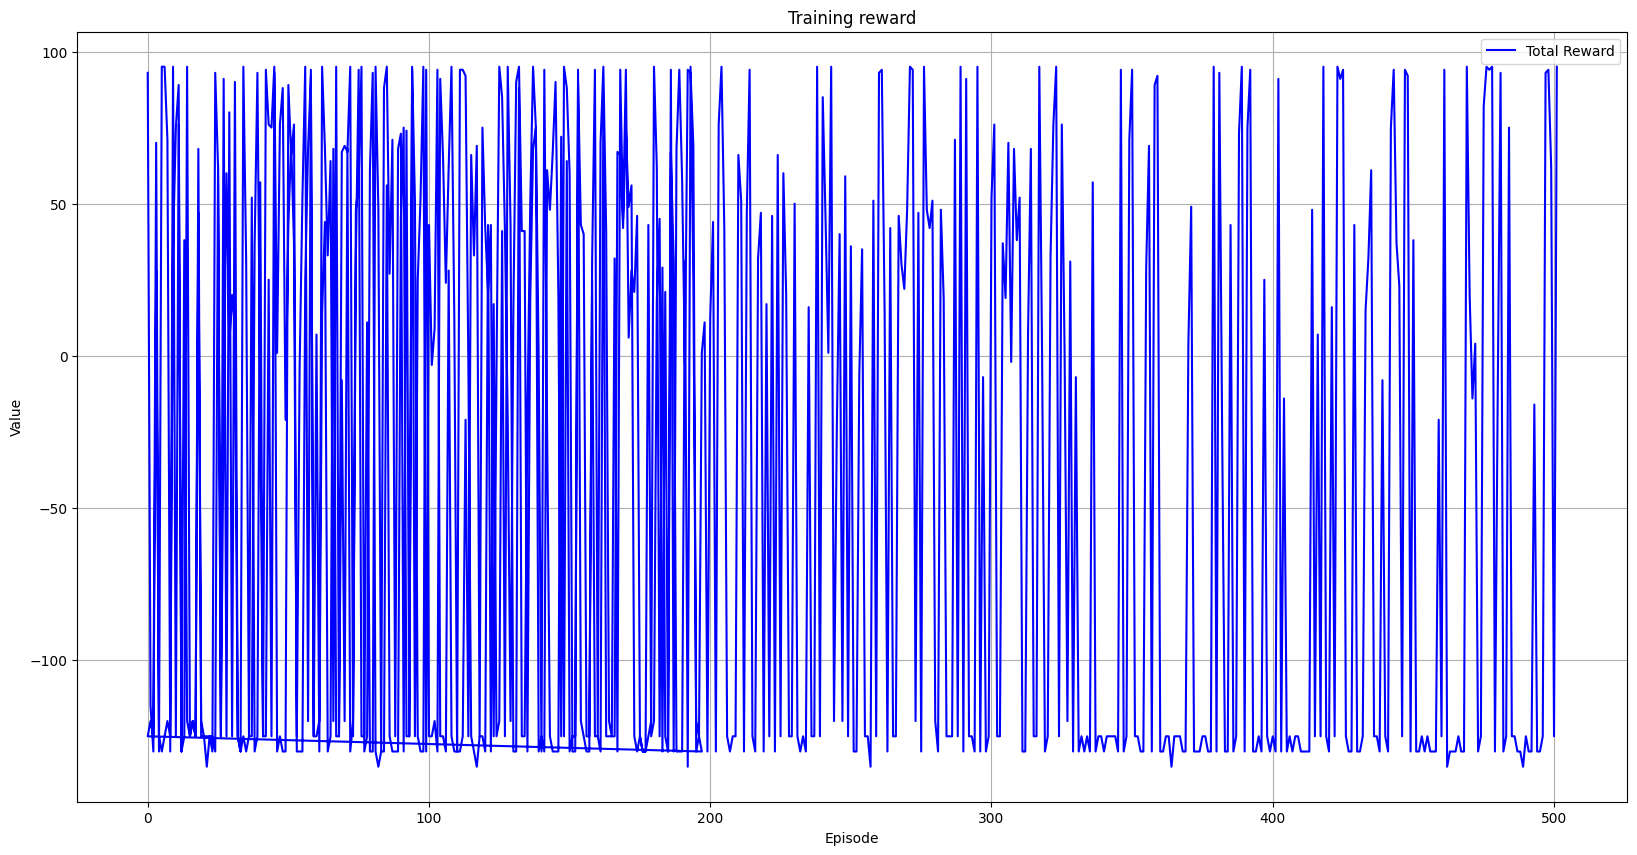

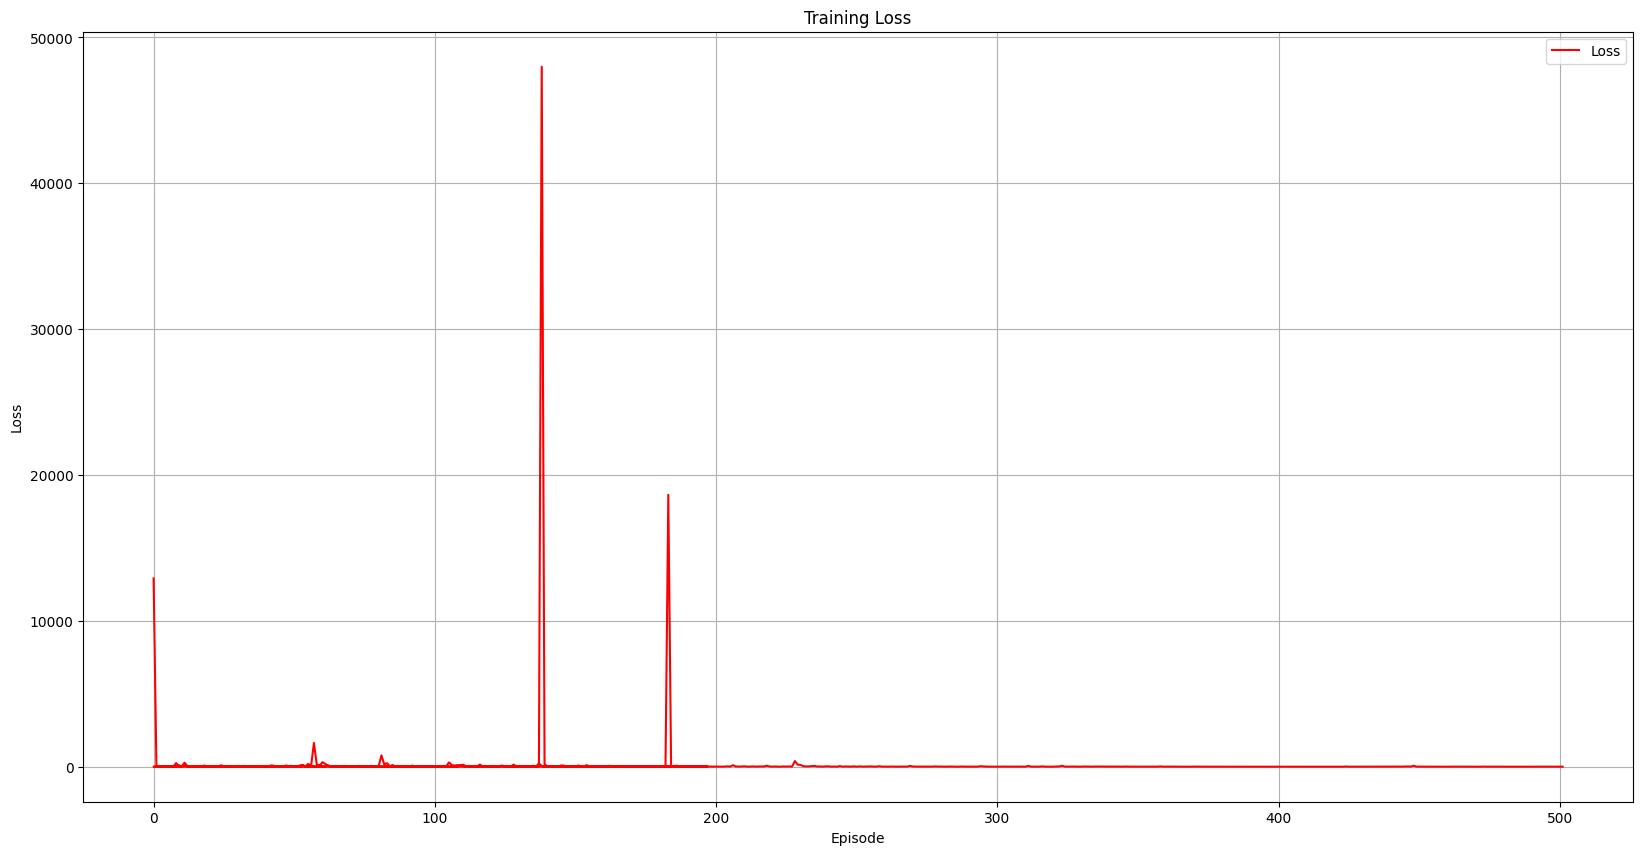

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

with open('leerdata_model_unchanged.txt', 'r') as f:
    lines = f.readlines()

episodes = []
rewards = []
losses = []

for line in lines:
    line_split = line.split('\t')
    word_parts = [part.split(':') for part in line_split]
    for part in word_parts:
        if part[0] == 'Episode':
            episodes.append(int(part[1]))
        elif 'Total' in part[0]:
            rewards.append(float(part[1]))
        elif 'Training' in part[0]:
            losses.append(float(part[1]))
    

# Plot
plt.figure(figsize=(20,10))
plt.plot(episodes, rewards, label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Training reward')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(20,10))
plt.plot(episodes, losses, label='Loss', color='red')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()



> *Antwoord*

<br>

---

### ❓Q4.b (6 punten)
Probeer nu de prestaties van het model te verbeteren en voer bovenstaande stappen nog eens uit. Dit kan je ondertussen op heel veel manieren doen, je kan bijvoorbeeld veranderingen maken aan de hyperparameters, exploratie regel, replay etc.

* Leg uit waarom je verwachtte dat jouw aanpassing het beter zou maken
* Laat zien of het werkte op basis van traingsgrafiek (stap 1 hierboven)
* Kijk goed naar het gedrag na 500 episodes leren of je daar iets van kan afleiden (stap 2 hierboven).

Het aantal trainings episodes is technische gezien een hyperparameter, maar die bedoelen we dus niet :)

**Let op:**
1. Elke keer voordat je een nieuwe training uitvoert met nieuwe hyperparameters moet je de game opnieuw initialseren: <br>
``
game, possible_actions = create_environment()
`` <br>

Dan is het geheugen van de CoLab instantie (RAM) ook weer leeg en het netwerk klaar om te gaan leren. Ook nu gaat het om je idee, niet meteen of het netwerk ook beter leert, maar dat is natuurlijk wel een mooie uitkomst!

In [74]:
# TO DO

> *Antwoord*

<br>

---

### ❓__Q5 (2 Punten)__
Bestudeer onderstaande code, hoe verschilt de decision policy van de gedrags simulatie met die van de training agent?

> *Antwoord*

In [75]:
# Assuming your DQNetwork and other required classes are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize environment
env = create_environment()
game, possible_actions_vizdoom, possible_actions_pytorch=env
state_size = [4, 84, 84]

# define which run and which episode you want to load
run_id=run_id
episode=150

# Load the model
model_path = f"./models/model_{run_id}/episode_{episode}.pth"
model = DQNetwork(state_size, len(possible_actions_pytorch)).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

game.init()

trajectories={}
num_samples=4

for i in range(num_samples):  # If you want to run more than one episode, change the range
    total_score = 0
    trajectory = []
    stacked_frames=[]
    done = False
    game.new_episode()
    state = game.get_state().screen_buffer
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    while not game.is_episode_finished():
        # Prepare state for the model
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # Get Q values for each action and choose the action with the highest Q
        Qs = model(state_tensor)
        choice = torch.argmax(Qs).item()
        action = possible_actions_vizdoom[choice]

        # Execute the action and get the reward
        game.make_action(action)
        done = game.is_episode_finished()

        if done:
            break
        else:
            next_state = game.get_state().screen_buffer
            trajectory.append(next_state)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state

    score = game.get_total_reward()
    print(f"Score game {i}: ", score)
    trajectories[f"game_{i}"]=trajectory
game.close()

Score game 0:  86.0
Score game 1:  92.0
Score game 2:  -310.0
Score game 3:  -320.0


In [76]:
import imageio

if not os.path.exists(f'./videos/{run_id}/'):
    os.makedirs(f'./videos/{run_id}/')

# Save to GIF
for game in range(num_samples):
    imageio.mimsave(f'./videos/{run_id}/video_{game}.gif', trajectories[f"game_{game}"], fps=15)
    print(f'trajectory game_{game} saved as ./videos/{run_id}/video_{game}.gif')

trajectory game_0 saved as ./videos/lr-0_02_bs-64_eps_dec-0_0001_gam-0_95/video_0.gif
trajectory game_1 saved as ./videos/lr-0_02_bs-64_eps_dec-0_0001_gam-0_95/video_1.gif
trajectory game_2 saved as ./videos/lr-0_02_bs-64_eps_dec-0_0001_gam-0_95/video_2.gif
trajectory game_3 saved as ./videos/lr-0_02_bs-64_eps_dec-0_0001_gam-0_95/video_3.gif


<br>

---

### Smart Exploration & Beyond..
Je hebt hier gezien dat we weer e-greedy gebruikte om met de explore exploit trade-off om te gaan. Maar we hadden eerder ook al wel gezien dat dit niet altijd de slimste of beste manier van exploratie is. We hebben UCB besproken die niet bezochte states een exploratie bonus geeft, en die bonus neemt af naarmate er meer over een staat geleerd is. Zo kom je niet meer terug bij "slechte" states.

Nu willen we niet alle mogelijk states per se bezoeken, van sommige kunnen we misschien al direct voorspellen dat deze niets gaan opleveren. In deze context is Curiosity Based Learning dus heel interessant. Kijk nogmaals naar [Curiosity driven learning](https://towardsdatascience.com/curiosity-driven-learning-made-easy-part-i-d3e5a2263359) voor een goede uitleg.

Het gaat nu te ver om hier dieper op in te gaan maar ik hoop dat door de basis te snappen van DQNs en dat dit je nu al een beter idee hebt hoe deze algoritmes werken. Probeer ook zeker zelf verschillende games van Vizdoom uit, of andere games zoals Space invaders. Er zijn eindeloos veel tutorials te vinden op het internet.